## Loading Image Data
So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a dataset of cat and dog photos available from Kaggle.

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from pathlib import Path
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

The easiest way to load image data is with datasets.ImageFolder from torchvision (documentation). In general you'll use ImageFolder like so:

`dataset = datasets.ImageFolder('path/to/data', transform=transform)`

where 'path/to/data' is the file path to the data directory and transform is a list of processing steps built with the transforms module from torchvision. ImageFolder expects the files and directories to be constructed like so:

root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png

where each class has it's own directory (cat and dog) for the images. The images are then labeled with the class taken from the directory name. So here, the image 123.png would be loaded with the class label cat.

## Transforms
When you load in the data with ImageFolder, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with transforms.Resize() or crop with transforms.CenterCrop(), transforms.RandomResizedCrop(), etc. We'll also need to convert the images to PyTorch tensors with transforms.ToTensor(). Typically you'll combine these transforms into a pipeline with transforms.Compose(), which accepts a list of transforms and runs them in sequence. It looks something like this to scale, then crop, then convert to a tensor:

`transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])`
                                 
There are plenty of transforms available, I'll cover more in a bit

## Data Loaders
With the ImageFolder loaded, you have to pass it to a DataLoader. The DataLoader takes a dataset (such as you would get from ImageFolder) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

`dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)`
Here dataloader is a generator. To get data out of it, you need to loop through it or convert it to an iterator and call next().

# Looping through it, get a batch on each loop 
`for images, labels in dataloader:
    pass`

# Get one batch
`images, labels = next(iter(dataloader))`
Exercise: Load images from the Cat_Dog_data/train folder, define a few transforms, then build the dataloader.

In [2]:
# plot img function
def imshow(image, ax=None, title=None, normalize=False, means=None, stds=None):
    '''Plot image for a tensor input'''
    image = image.numpy().transpose((1, 2, 0))
    
    if not ax:
        fig, ax = plt.subplots(figsize=(6,4))
       
    if normalize:
        mean = np.array(means) # channel means
        std = np.array(stds) # channel stds
        image = image*std + mean 
        image = np.clip(image, 0, 1)
        
    ax.imshow(image)
    ax.spines['top'].set_visible = False
    ax.spines['bottom'].set_visible = False
    ax.spines['left'].set_visible = False
    ax.spines['right'].set_visible = False
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    return ax  

Note:
------
- To plot an image in numpy representation using matplot, use the format (H x W x C) instead of default torch format (C x H x W).
- clip values between 0 and 1: pytorch likes the values to be between 0 and 1 for the tensor.

# Data Augmentation
A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

`train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])`
You'll also typically want to normalize images with transforms.Normalize. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

`input[channel] = (input[channel] - mean[channel]) / std[channel]`

Subtracting mean centers the data around zero and dividing by std squishes the values to be between -1 and 1. Normalizing helps keep the network work weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all the available transforms here. When you're testing however, you'll want to use images that aren't altered (except you'll need to normalize the same way). So, for validation/test images, you'll typically just resize and crop.

Exercise: Define transforms for training data and testing data below. Leave off normalization for now.

In [3]:
dpath = Path('D:/work/workspace/machine_learning/Datasets/Cat_Dog_data')

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                    transforms.RandomResizedCrop(64),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize([0.5, 0.5, 0.5],
                                                         [0.5, 0.5, 0.5])])
test_transform = transforms.Compose([transforms.Resize(64),
                                    transforms.CenterCrop(64),
                                    transforms.ToTensor(), 
                                    transforms.Normalize([0.5, 0.5, 0.5],
                                                         [0.5, 0.5, 0.5])])

trainset = datasets.ImageFolder(str(dpath/'train'), transform=train_transform)
testset = datasets.ImageFolder(str(dpath/'test'), transform=test_transform)
 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


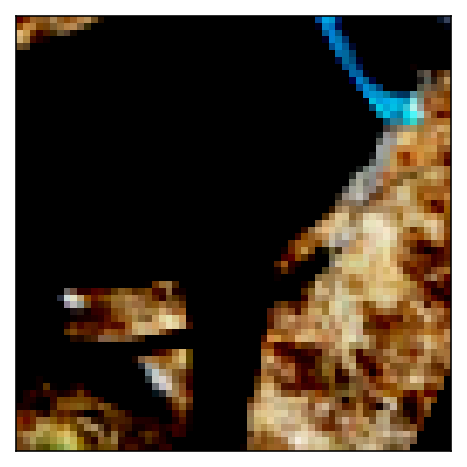

In [4]:
# test data loaded properly
images, labels = next(iter(trainloader))
imshow(images[0])
plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


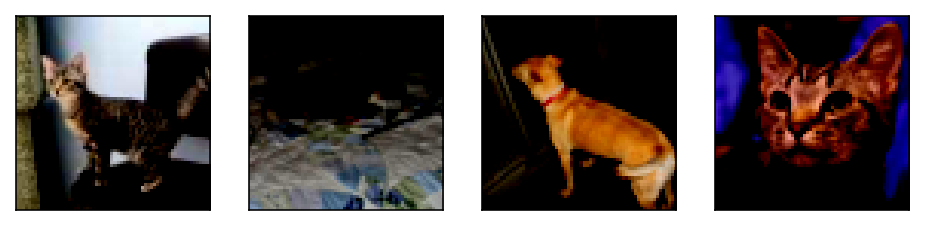

In [5]:
# plot multiple images 
images, labels = next(iter(testloader))

fig, ax = plt.subplots(figsize=(8,6), ncols=4)
ax = ax.ravel()

for i in range(4):
    imshow(images[i], ax=ax[i])